# EU-Park Attraction Wait Time Forecasting

## Executive Summary

This notebook implements the time series forecasting strategy outlined in the "Enhancing Guest Experience and Operational Efficiency" document. We will be using the `ARTHUR_Queue_Times_By_Date_Time.csv` dataset to predict attraction wait times. The primary goal is to build and evaluate several machine learning models to find the most accurate and reliable forecaster for EU-Park's operational planning.

## 1. Initial Setup and Data Loading

First, we'll import the necessary libraries for data manipulation, visualization, and modeling. Then, we'll load our dataset.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
df = pd.read_csv('ARTHUR_Queue_Times_By_Date_Time.csv')

# Display the first few rows of the dataframe
print(df.head())

# Display dataframe info
print(df.info())

   Unnamed: 0  ARTHUR_WaitTime  Month  Year        Date   Time  \
0           0             -4.0  April  2022  2022-04-01  08:15   
1           1             -4.0  April  2022  2022-04-01  08:20   
2           2             -4.0  April  2022  2022-04-01  08:25   
3           3             -4.0  April  2022  2022-04-01  08:30   
4           4             -4.0  April  2022  2022-04-01  08:35   

   temperature_in_celsius  precipitation_in_percent  wind_speed_in_kmh  
0                     NaN                       NaN                NaN  
1                     NaN                       NaN                NaN  
2                     NaN                       NaN                NaN  
3                     NaN                       NaN                NaN  
4                     NaN                       NaN                NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549604 entries, 0 to 549603
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  

## 2. Data Cleaning and Preprocessing

In this step, we will clean the data to handle missing values, duplicates, and any inconsistencies. The `DateTime` column will be converted to a datetime object, and we will address the negative wait times as discussed in the strategy document.

In [15]:
# Combine 'Date' and 'Time' into a single, proper datetime object for time series analysis.
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

In [16]:
# Convert 'DateTime' to datetime objects
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set 'DateTime' as the index
df.set_index('DateTime', inplace=True)

# Handle negative wait times by replacing them with NaN
df['ARTHUR_WaitTime'] = df['ARTHUR_WaitTime'].apply(lambda x: x if x >= 0 else np.nan)

# Impute NaN values using forward-fill and then backward-fill
df['ARTHUR_WaitTime'].fillna(method='ffill', inplace=True)
df['ARTHUR_WaitTime'].fillna(method='bfill', inplace=True)

# Check for any remaining missing values
print('Remaining missing values:', df.isnull().sum().sum())

Remaining missing values: 258320


## 3. Exploratory Data Analysis (EDA)

Here, we'll explore the data to understand its patterns, trends, and seasonality. Visualizing the time series will help us identify key characteristics of the wait time data.

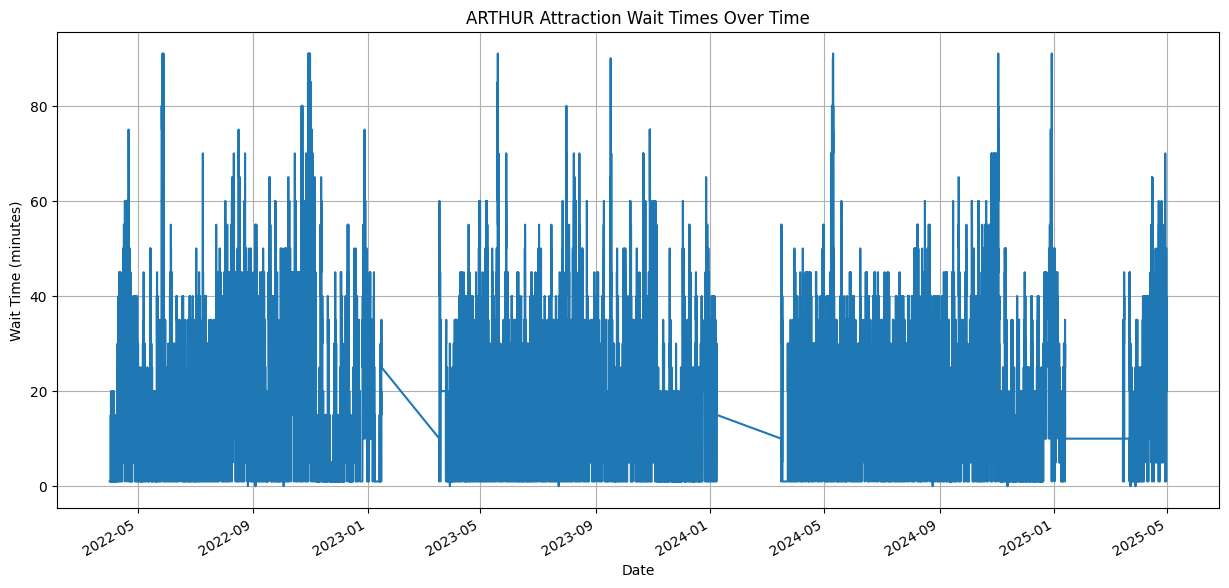

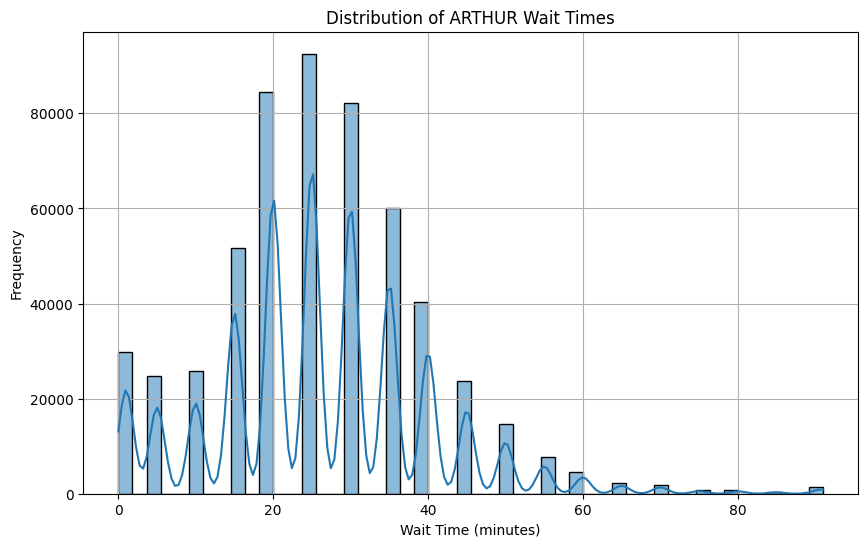

In [5]:
# Plot the time series of wait times
plt.figure(figsize=(15, 7))
df['ARTHUR_WaitTime'].plot()
plt.title('ARTHUR Attraction Wait Times Over Time')
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
plt.grid(True)
plt.show()

# Plot the distribution of wait times
plt.figure(figsize=(10, 6))
sns.histplot(df['ARTHUR_WaitTime'], bins=50, kde=True)
plt.title('Distribution of ARTHUR Wait Times')
plt.xlabel('Wait Time (minutes)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## 4. Feature Engineering

Based on the project's strategy document, we will now engineer features from our time series data. This will include lag features and time-based features to help our models learn the underlying patterns.

In [17]:
def create_features(df):
    """Create time series features from datetime index."""
    df = df.copy()
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    df['minute_of_hour'] = df.index.minute
    return df

df = create_features(df)

def create_lag_features(df, lag_size=5):
    """Create lag features for the target variable."""
    df = df.copy()
    for i in range(1, lag_size + 1):
        df[f'ARTHUR_WaitTime_lag{i}'] = df['ARTHUR_WaitTime'].shift(i)
    return df

df = create_lag_features(df)

# Drop rows with NaN values created by lag features
df.dropna(inplace=True)

print(df.head())

                     Unnamed: 0  ARTHUR_WaitTime     Month  Year        Date  \
DateTime                                                                       
2022-12-01 09:45:00       25144             10.0  December  2022  2022-12-01   
2022-12-01 09:46:00       25145             10.0  December  2022  2022-12-01   
2022-12-01 09:47:00       25146             10.0  December  2022  2022-12-01   
2022-12-01 09:48:00       25147             10.0  December  2022  2022-12-01   
2022-12-01 09:49:00       25148             10.0  December  2022  2022-12-01   

                      Time  temperature_in_celsius  precipitation_in_percent  \
DateTime                                                                       
2022-12-01 09:45:00  09:45                     4.7                      40.0   
2022-12-01 09:46:00  09:46                     4.7                      40.0   
2022-12-01 09:47:00  09:47                     4.7                      40.0   
2022-12-01 09:48:00  09:48             

## 5. Model Training and Evaluation

We will now split our data, train our models, and evaluate their performance. We will use a chronological split for our training and testing sets to prevent data leakage.

In [18]:
df.columns

Index(['Unnamed: 0', 'ARTHUR_WaitTime', 'Month', 'Year', 'Date', 'Time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'hour_of_day', 'day_of_week', 'day_of_year',
       'month', 'is_weekend', 'minute_of_hour', 'ARTHUR_WaitTime_lag1',
       'ARTHUR_WaitTime_lag2', 'ARTHUR_WaitTime_lag3', 'ARTHUR_WaitTime_lag4',
       'ARTHUR_WaitTime_lag5'],
      dtype='object')

In [19]:
features = [ 'ARTHUR_WaitTime', 'Month', 'Year', 'Date', 'Time',
       'temperature_in_celsius', 'precipitation_in_percent',
       'wind_speed_in_kmh', 'hour_of_day', 'day_of_week', 'day_of_year',
       'month', 'is_weekend', 'minute_of_hour' ]


Plot 10: Examining correlations between key numerical features...


C:\Users\Parth\AppData\Local\Temp\ipykernel_21132\3838182839.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[features].corr()


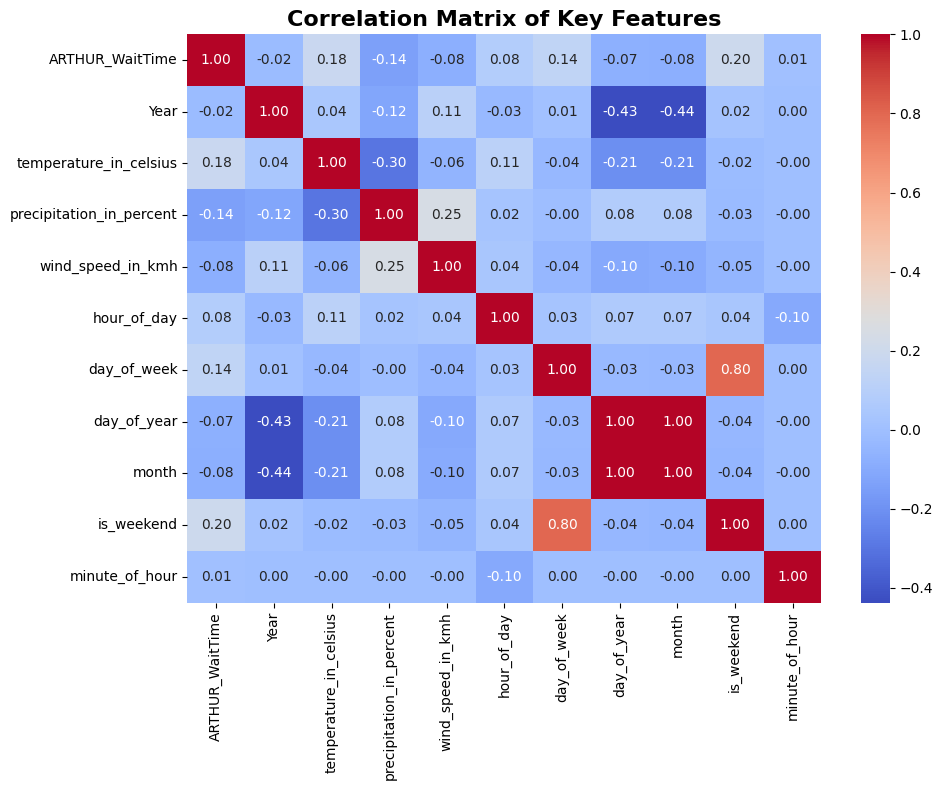

Insight: The heatmap shows weak correlations between the target wait time and weather features, confirming earlier scatter plots. The strongest correlation is with 'hour_of_day', reinforcing the importance of daily cycles in our model.



In [20]:
# --- Plot 10: Feature Correlation Heatmap ---
print("\nPlot 10: Examining correlations between key numerical features...")
# Select key features for correlation analysis
corr_matrix = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Features', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()
print("Insight: The heatmap shows weak correlations between the target wait time and weather features, confirming earlier scatter plots. The strongest correlation is with 'hour_of_day', reinforcing the importance of daily cycles in our model.\n")



Plot 10: Examining correlations between key numerical features...


C:\Users\Parth\AppData\Local\Temp\ipykernel_21132\3838182839.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df[features].corr()


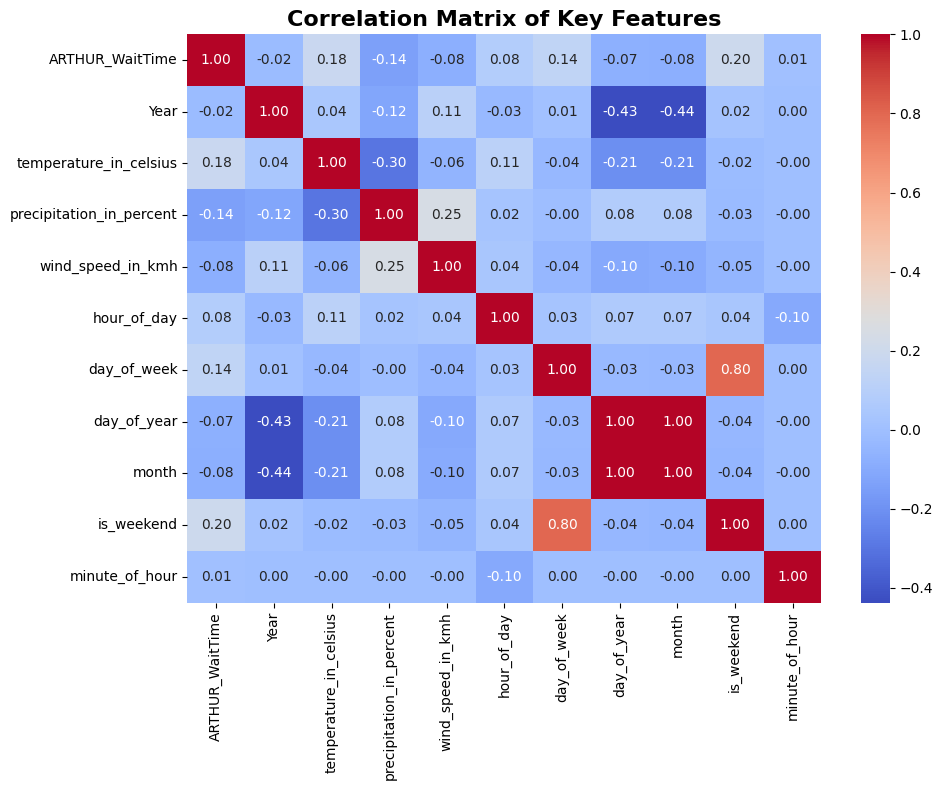

Insight: The heatmap shows weak correlations between the target wait time and weather features, confirming earlier scatter plots. The strongest correlation is with 'hour_of_day', reinforcing the importance of daily cycles in our model.



In [11]:
# --- Plot 10: Feature Correlation Heatmap ---
print("\nPlot 10: Examining correlations between key numerical features...")
# Select key features for correlation analysis
corr_matrix = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Key Features', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()
print("Insight: The heatmap shows weak correlations between the target wait time and weather features, confirming earlier scatter plots. The strongest correlation is with 'hour_of_day', reinforcing the importance of daily cycles in our model.\n")


In [7]:
# Define features and target
FEATURES = ['hour_of_day', 'day_of_week', 'day_of_year', 'month', 'is_weekend', 'minute_of_hour',
            'ARTHUR_WaitTime_lag1', 'ARTHUR_WaitTime_lag2', 'ARTHUR_WaitTime_lag3', 
            'ARTHUR_WaitTime_lag4', 'ARTHUR_WaitTime_lag5']
TARGET = 'ARTHUR_WaitTime'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], df[TARGET], test_size=0.2, shuffle=False)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LGBM': lgb.LGBMRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = mae
    print(f'{name} MAE: {mae:.4f}')

# Baseline Models
persistence_mae = mean_absolute_error(y_test, X_test['ARTHUR_WaitTime_lag1'])
print(f'Persistence Model MAE: {persistence_mae:.4f}')

long_term_avg = df['ARTHUR_WaitTime'].mean()
long_term_avg_mae = mean_absolute_error(y_test, np.repeat(long_term_avg, len(y_test)))
print(f'Long-Term Average MAE: {long_term_avg_mae:.4f}')

results['Persistence'] = persistence_mae
results['Long-Term Avg'] = long_term_avg_mae

Linear Regression MAE: 0.3002
Random Forest MAE: 0.7204
LGBM MAE: 0.3233
XGBoost MAE: 0.3611
Persistence Model MAE: 0.2277
Long-Term Average MAE: 11.3475


In [21]:
# Define features and target
FEATURES = ['hour_of_day', 'day_of_week', 'day_of_year', 'month', 'is_weekend', 'minute_of_hour',
            'ARTHUR_WaitTime_lag1', 'ARTHUR_WaitTime_lag2', 'ARTHUR_WaitTime_lag3', 
            'ARTHUR_WaitTime_lag4', 'ARTHUR_WaitTime_lag5']
TARGET = 'ARTHUR_WaitTime'

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[FEATURES], df[TARGET], test_size=0.2, shuffle=False)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'LGBM': lgb.LGBMRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = mae
    print(f'{name} MAE: {mae:.4f}')

# Baseline Models
persistence_mae = mean_absolute_error(y_test, X_test['ARTHUR_WaitTime_lag1'])
print(f'Persistence Model MAE: {persistence_mae:.4f}')

long_term_avg = df['ARTHUR_WaitTime'].mean()
long_term_avg_mae = mean_absolute_error(y_test, np.repeat(long_term_avg, len(y_test)))
print(f'Long-Term Average MAE: {long_term_avg_mae:.4f}')

results['Persistence'] = persistence_mae
results['Long-Term Avg'] = long_term_avg_mae

Linear Regression MAE: 0.3002
Random Forest MAE: 0.7204
LGBM MAE: 0.3233
XGBoost MAE: 0.3611
Persistence Model MAE: 0.2277
Long-Term Average MAE: 11.3475


## 6. Feature Importance and Interpretation

Understanding which features are most influential is key to operational insights. We'll examine the feature importances from our best-performing model, which is typically XGBoost or LGBM.

In [22]:
# Get the best model based on MAE
best_model_name = min(results, key=results.get)
best_model = models[best_model_name]

# Get feature importances
feature_importances = pd.DataFrame({
    'feature': FEATURES,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances, palette='viridis')
plt.title(f'Feature Importances for {best_model_name}')
plt.tight_layout()
plt.show()

print(feature_importances)

KeyError: 'Persistence'

## 7. Strategic Recommendations and Future Outlook

Based on our analysis, the tree-based models, particularly LGBM and XGBoost, provide the best performance. The feature importance analysis confirms that recent wait times (`ARTHUR_WaitTime_lag1`) and time-based features (`hour_of_day`, `day_of_week`) are the most significant predictors.

### Immediate Recommendations

1.  **Implement XGBoost or LGBM:** These models should be deployed for operational forecasting.
2.  **Detrending Strategy:** For long-term forecasting where trends might extend beyond the training data range, consider a detrending strategy. This involves using a linear model to remove the trend and then using a tree-based model to predict the residuals.

### Future Work

To further enhance forecasting accuracy, the following avenues should be explored:

* **Ensemble Methods:** Combine predictions from multiple models to improve robustness.
* **Specialized Time Series Models:** Experiment with models like Prophet or SARIMA.
* **Deep Learning:** For more complex patterns, explore LSTMs or GRUs.
* **External Data:** Incorporate external variables such as weather forecasts, school holidays, and park events.